In [84]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold

from collections import defaultdict,Counter
# from imblearn.over_sampling import SMOTE
from PIL import Image

# from kerastuner import HyperModel

In [85]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
def generate_actual_predicted(Y_pred, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [86]:
import numpy as np

actual= np.load('Jetson_ALL_TensorRT_Results/y_actual_jetsonmel_smote_v1_iter_1.npy', allow_pickle= True)
predicted= np.load('Jetson_ALL_TensorRT_Results/y_pred_jetsonmel_smote_v1_iter_1.npy', allow_pickle= True)

np.unique(actual)


array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [87]:
predicted

array([4, 4, 7, ..., 1, 4, 4], dtype=int64)

In [88]:
Y_predicted_ohe= np_utils.to_categorical(actual, num_classes=8) 
Y_test=np_utils.to_categorical(predicted, num_classes=8) 

In [89]:
Y_test.shape

(3018, 8)

In [90]:
# loading a test image
import os
from PIL import Image

X_all = []
Y_all = []

image_folder_path = r'C:\Users\azada\Documents\Uni Files\Non-Academic Uni Files\Bat Project\Repositories\Team Repository\DeepLearningBatDetector\data\SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))
    

    
X_all = np.array(X_all)
Y_all = np.array(Y_all)



X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


print(X_all.shape)
print(Y_all.shape)

(3018, 112, 170, 3)
(3018, 8)


## K_fold Evaluation

In [91]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix



all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

count = 1
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):
    y_actual= np.load('Jetson_ALL_TensorRT_Results/y_actual_jetsonmel_smote_v1_iter_'+str(count)+'.npy', allow_pickle= True)
    y_predicted =np.load('Jetson_ALL_TensorRT_Results/y_pred_jetsonmel_smote_v1_iter_'+str(count)+'.npy', allow_pickle= True)

    y_predicted_ohe= np_utils.to_categorical(y_predicted, num_classes=8) 
    y_actual_ohe=np_utils.to_categorical(y_actual, num_classes=8) 
    
    
    
    # use the index to generate training an testing sets
    current_y_pred,current_y_test=y_predicted_ohe[test_index],y_actual_ohe[test_index]
    
    print('Evaluating iter '+ str(count))
    print(current_y_pred.shape)

    actual, predicted = generate_actual_predicted(current_y_pred, current_y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_actual_ohe[:,i], y_predicted_ohe[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_actual_ohe[:,i], y_predicted_ohe[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    count+=1


Evaluating iter 1
(302, 8)
Evaluating iter 2
(302, 8)
Evaluating iter 3
(302, 8)
Evaluating iter 4
(302, 8)
Evaluating iter 5
(302, 8)
Evaluating iter 6
(302, 8)
Evaluating iter 7
(302, 8)
Evaluating iter 8
(302, 8)
Evaluating iter 9
(301, 8)
Evaluating iter 10
(301, 8)


In [92]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  0.974
Std  0.03104834939252005
Sp:  E.bottae
AUC Mean  0.9316015337628464
Std  0.059673171213411286
Sp:  M.emarginatus
AUC Mean  0.947834836790876
Std  0.059525988634141117
Sp:  P.kuhli
AUC Mean  0.9380471991350351
Std  0.12422012996173645
Sp:  R.muscatellum
AUC Mean  0.9396567520957764
Std  0.09220171607127005
Sp:  R.nasutus
AUC Mean  0.9513898261077701
Std  0.07070914363091164
Sp:  R.aegyptius
AUC Mean  0.9456384062167474
Std  0.10408857336749355
Sp:  T.perforatus
AUC Mean  0.9042544681618265
Std  0.10192583031000164


In [93]:
#print('precision mean by class', np.array(all_base_precision).mean(axis=0))
#print('precision sdev by class', np.array(all_base_precision).std(axis=0))

#print('macro precision mean', np.array(all_macro_precision).mean())
#print('macro precision sdev', np.array(all_macro_precision).std())


#print('recall mean', np.array(all_base_recall).mean(axis=0))
#print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

#print('f1 mean', np.array(all_f1).mean(axis=0))
#print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



macro recall mean 0.8994082132710887
macro recall sdev 0.1264691566898455
macro f1 mean 0.9166799033118229
macro f1 sdev 0.1034636996376276
accuracy mean 0.9307793007854613
accuracy sdev 0.08132265005412996


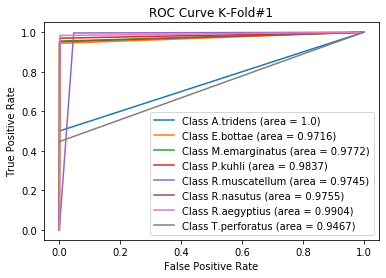

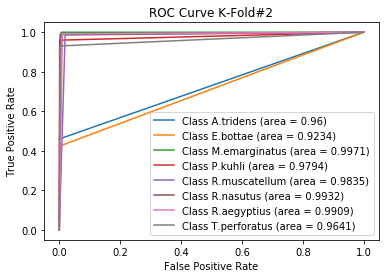

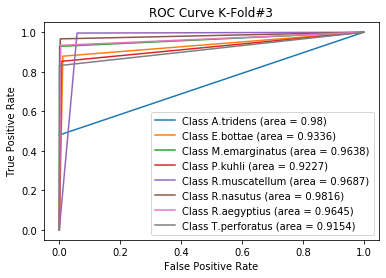

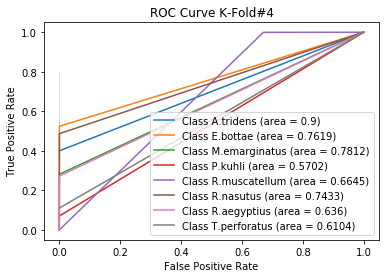

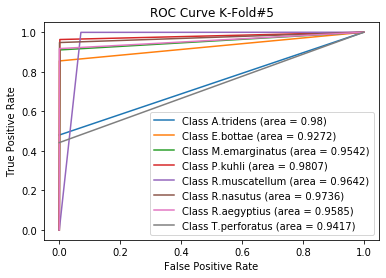

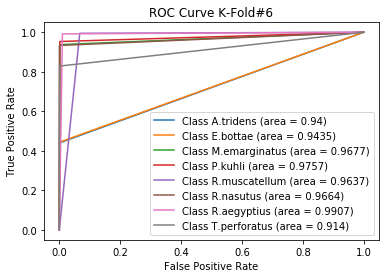

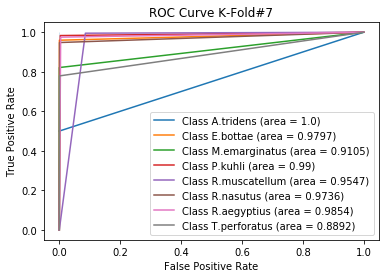

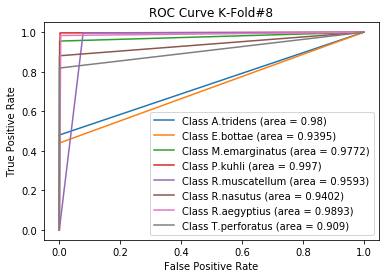

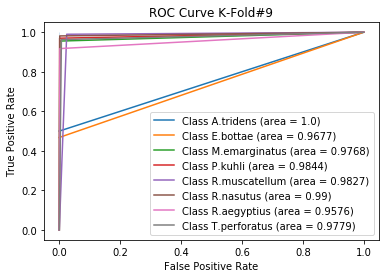

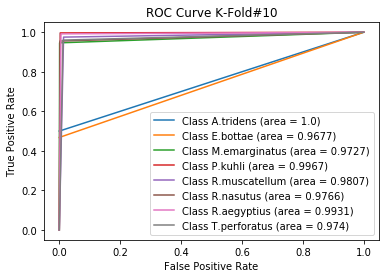

In [94]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

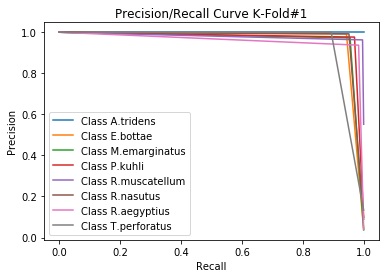

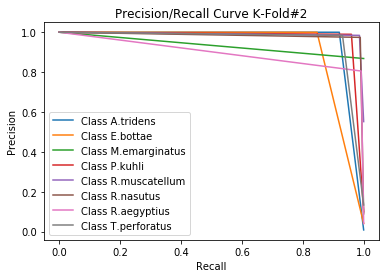

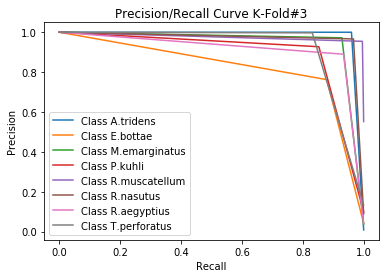

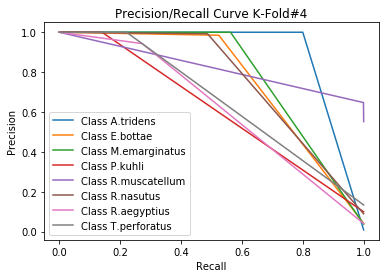

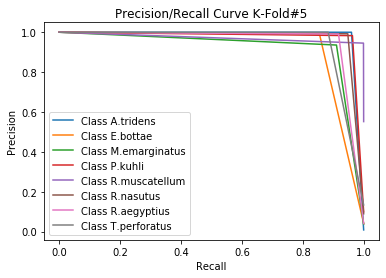

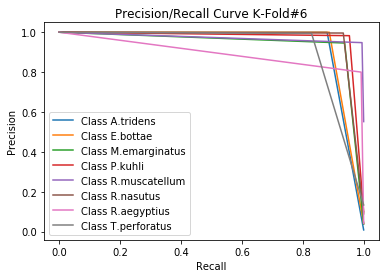

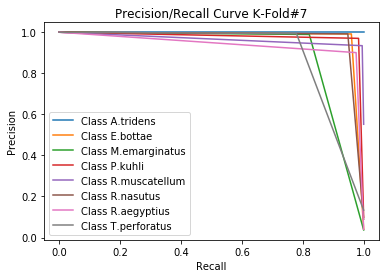

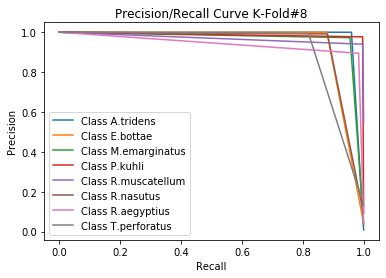

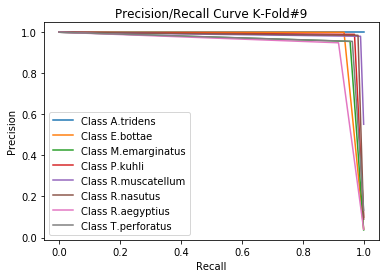

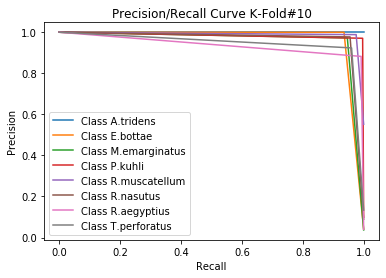

In [95]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0   9   0   0   0   0   0   0]
 [  0   0   7   0   0   0   0   0]
 [  0   0   0  32   2   0   0   0]
 [  0   0   0   0 176   0   1   0]
 [  0   0   0   0   0  29   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   3   0   0  30]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0   6   0   0   3   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  27   1   0   0   2]
 [  0   0   1   0 175   0   2   0]
 [  0   0   0   0   0  18   0   0]
 [  0   0   0   0   0   0  15   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  18   0   0   0   0   0   0]
 [  0   0  17   0   2   0   0   0]
 [  0   3   0  32   1   0   0   0]
 [  0   0   0   0 160   0   1   0]
 [  0   0   0   1   0  16   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   2   5   0   1  28]]


Confusion Matrix K-Fold #4

[[  0   0   0   0   0   0   0   0]
 [  

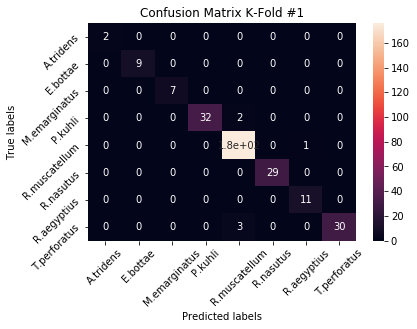

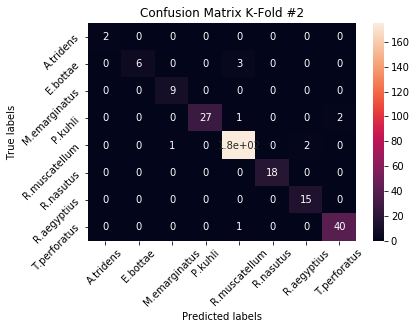

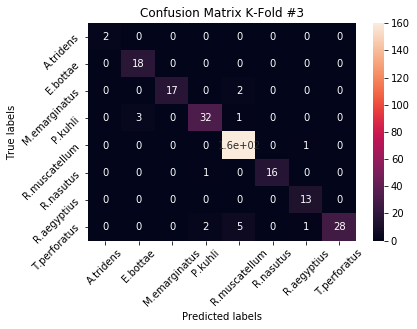

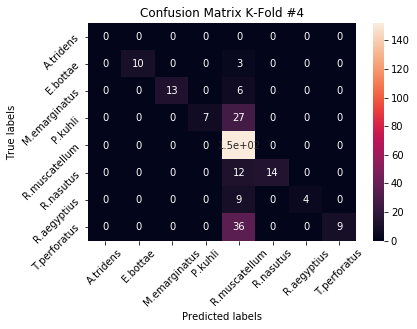

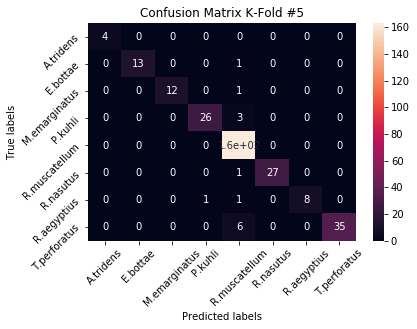

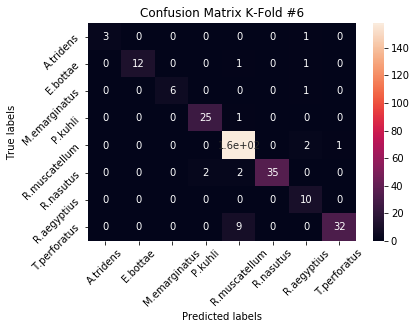

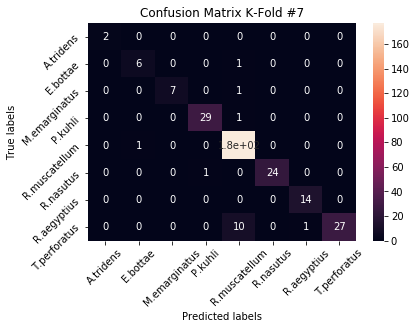

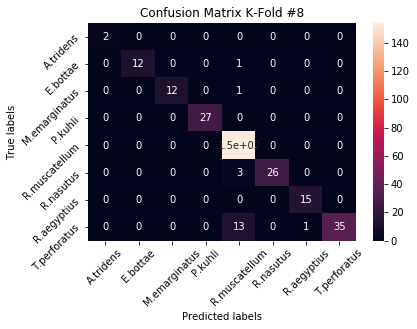

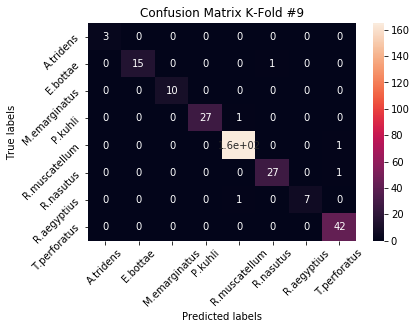

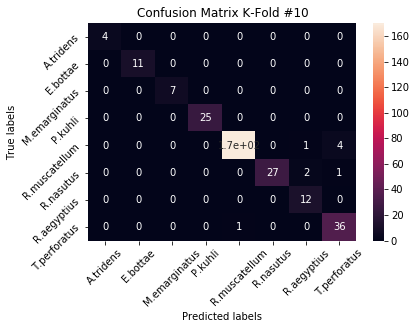

In [96]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  24    0    0    0    0    0    1    0]
 [   0  112    0    0   10    1    1    0]
 [   0    0  100    0   11    0    1    0]
 [   0    3    0  257   37    0    0    2]
 [   0    1    1    0 1650    0    7    6]
 [   0    0    0    4   18  243    2    2]
 [   0    0    0    1   11    0  109    0]
 [   0    0    0    2   84    0    3  314]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   1   0   0   0]
 [  0   0  10   0   1   0   0   0]
 [  0   0   0  25   3   0   0   0]
 [  0   0   0   0 165   0   0   0]
 [  0   0   0   0   1  24   0   0]
 [  0   0   0   0   1   0  10   0]
 [  0   0   0   0   8   0   0  31]]


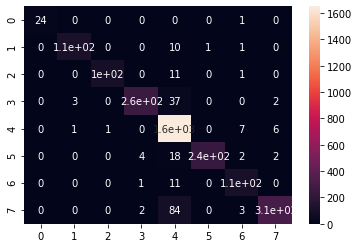

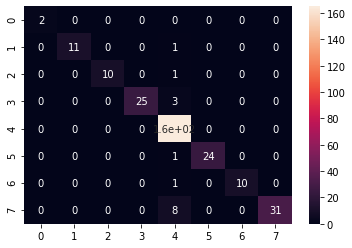

In [97]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.96 0.   0.   0.   0.   0.   0.04 0.  ]
 [0.   0.9  0.   0.   0.08 0.01 0.01 0.  ]
 [0.   0.   0.89 0.   0.1  0.   0.01 0.  ]
 [0.   0.01 0.   0.86 0.12 0.   0.   0.01]
 [0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.07 0.9  0.01 0.01]
 [0.   0.   0.   0.01 0.09 0.   0.9  0.  ]
 [0.   0.   0.   0.   0.21 0.   0.01 0.78]]


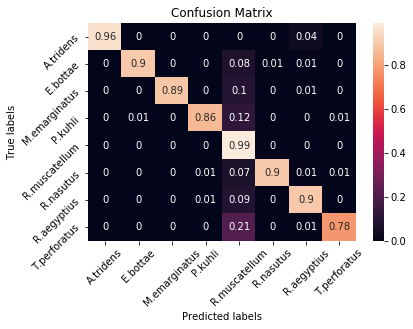

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

## Appendix- what each interpreter function does or looks like

In [19]:
input_details = interpreter.get_input_details()
print (input_details) # stores the details in key value format of the input layer at the top

[{'name': 'input_3', 'index': 0, 'shape': array([  1, 112, 170,   3]), 'shape_signature': array([ -1, 112, 170,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [20]:
output_details = interpreter.get_output_details()
print (output_details) # stores the details in key value format of the output layer at the the end of the model

[{'name': 'Identity', 'index': 25, 'shape': array([1, 8]), 'shape_signature': array([-1,  8]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
output_details[0]['index']

25

In [21]:
print (interpreter.allocate_tensors())

None
